# Eight schools models

This notebook explains how to use the classic Eight schools example from [1]. This model was used to determine the effects of coaching on SATS scores in 8 schools. This model is hierarchical and takes the form,

$\mu\sim\mathcal{N}(0, 5),$

$\tau\sim\text{half-Cauchy}(0, 5),$

$\theta_j\sim\mathcal{N}(\mu,\tau),$

$y_j\sim\mathcal{N}(\theta_j,\sigma_j)$,

where $\theta_j$ are the school-level mean scores, $\mu$ and $\tau$ are the population-level mean and standard deviation, $\sigma_j$ are known school-level standard deviations, and $y_j$ are the recorded scores.

This notebook actually covers two sister parameterisations of the above statistical model. The simplest, which mirrors the above statistical model exactly, is known as the "centered" parameterisation. The "non-centered" version introduces auxillary variables, $\bar\theta_j$, such that the joint distribution $p(\mu,\tau,\theta|y)$ remains unchanged but is easier to sample from. It does this by rewriting the middle two expressions above as,

$\bar\theta_j \sim\mathcal{N}(0, 1),$

$\theta_j = \mu + \tau \bar\theta_j.$

[1] "Bayesian data analysis", 3rd edition, 2014, Gelman, A et al..

## Centered model

All of $\sigma_j$ and $y_j$ for $j=1,...,8$ are provided as data that accompany this model. 

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pints
import pints.toy
import pints.plot
from scipy import stats

# Create log pdf
model = pints.toy.EightSchoolsLogPDF()

# get data
data = model.data()

print(data)

{'J': 8, 'y': [28, 8, -3, 7, -1, 1, 18, 12], 'sigma': [15, 10, 16, 11, 9, 11, 10, 18]}


Setting all $\theta_j=4$, we can plot the joint distribution of $(\mu, \tau)$ and can see a funnel shape reminiscient of [Neal's funnel](distribution-neals-funnel.ipynb); perhaps hinting that sampling from this model may be tricky.

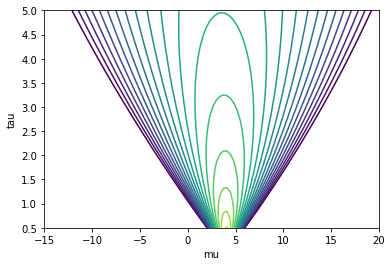

In [2]:
# Plot marginal density
theta_j = (4 * np.ones(8)).tolist()
levels = np.linspace(-100, -30, 20)
mu = np.linspace(-15, 20, 100)
tau = np.linspace(0.5, 5, 100)
X, Y = np.meshgrid(mu, tau)
Z = [[model([i, j] + theta_j) for i in mu] for j in tau]
plt.contour(X, Y, Z, levels)
plt.xlabel('mu')
plt.ylabel('tau')
plt.show()

We can also plot the marginal density of $(\mu,\theta_1)$ and see some correlation between the two dimensions.

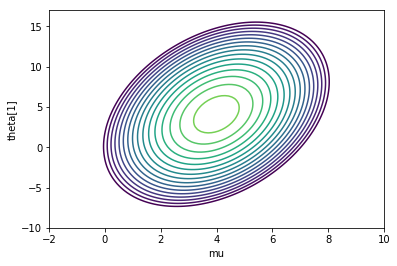

In [3]:
# Plot marginal density
theta_j = (4 * np.ones(7)).tolist()
levels = np.linspace(-100, -30, 20)
mu = np.linspace(-2, 10, 100)
theta_1 = np.linspace(-10, 17, 100)
X, Y = np.meshgrid(mu, theta_1)
Z = [[model([i, 1, j] + theta_j) for i in mu] for j in theta_1]
plt.contour(X, Y, Z, levels)
plt.xlabel('mu')
plt.ylabel('theta[1]')
plt.show()

Since this model comes with gradients, we can use Hamiltonian Monte Carlo to sample from the posterior.

In [4]:
# initialisation
xs = [4 + np.random.normal(size=10) for chain in range(4)]
# set 1st element of each list to positive number since corresponds to a scale parameter
for x in xs:
    x[1] = np.random.uniform()

# create controller object
mcmc = pints.MCMCController(model, len(xs), xs, method=pints.HamiltonianMCMC)

# Add stopping criterion
mcmc.set_max_iterations(1000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(100)

# # Update step sizes used by individual samplers
for sampler in mcmc.samplers():
    sampler.set_leapfrog_step_size(0.1)

# Run!
print('Running...')
full_chains = mcmc.run()
print('Done!')

Running...
Using Hamiltonian Monte Carlo
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.0
1     84     0.333     0.333     0         0.333      0:00.0
2     164    0.5       0.5       0         0.5        0:00.1
3     244    0.6       0.6       0         0.6        0:00.1
100   8004   0.98      0.98      0         0.98       0:02.6
200   16004  0.990099  0.990099  0         0.990099   0:05.0
300   24004  0.993     0.993     0         0.993      0:07.5
400   32004  0.995     0.995     0         0.995      0:09.9
500   40004  0.996     0.996     0         0.996      0:12.5
600   48004  0.997     0.997     0         0.997      0:15.2
700   56004  0.997151  0.997151  0         0.997151   0:17.5
800   64004  0.998     0.99      0         0.998      0:20.1
900   72004  0.991     0.98      0         0.998      0:22.5
1000  79924  0.991009  0.981019  0         0.998002   0:

This doesn't look great -- the chains are not mixing well indicating slow convergence to the posterior.

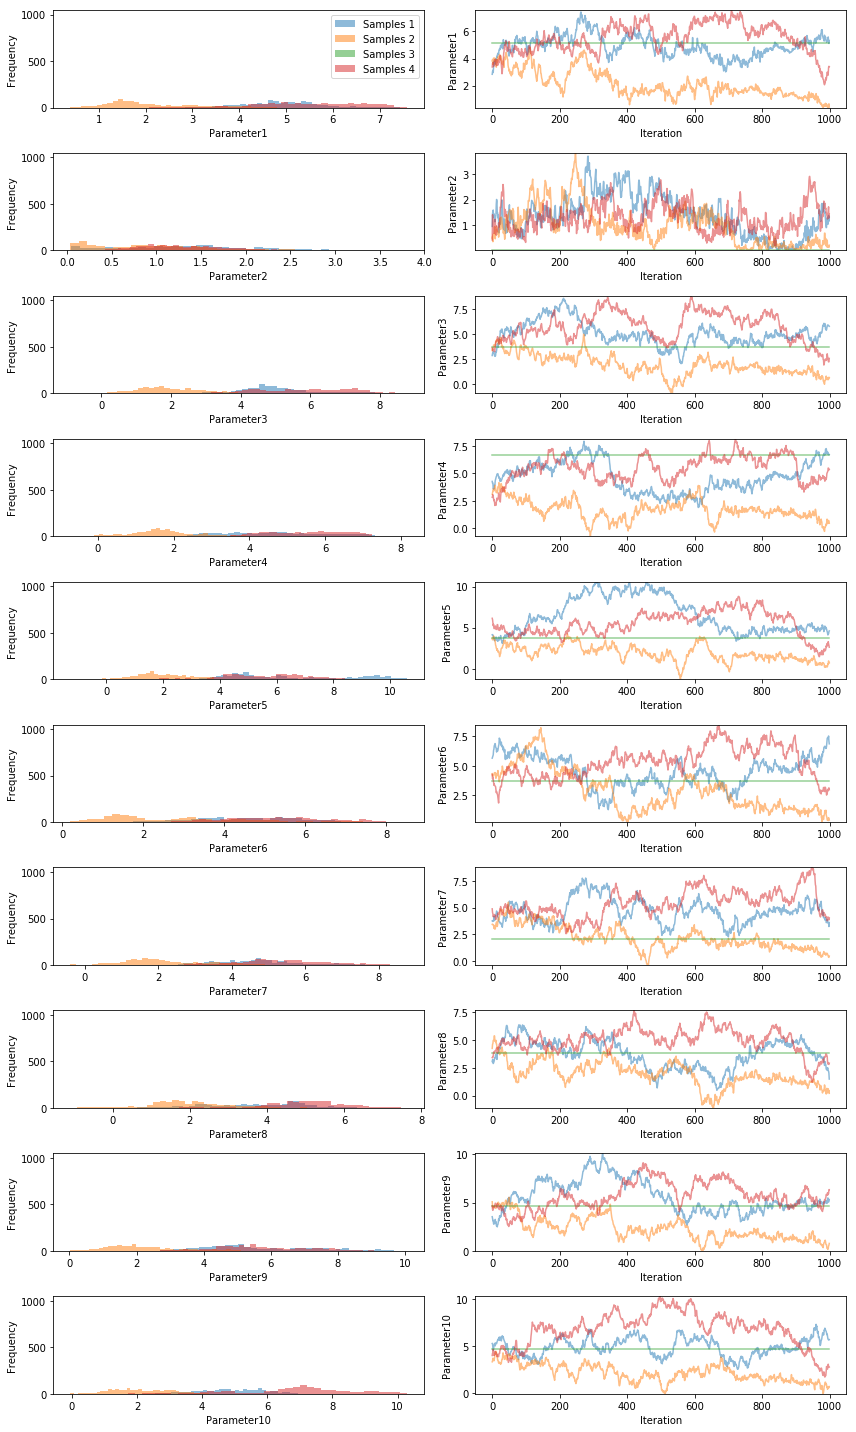

In [5]:
import pints.plot
pints.plot.trace(full_chains)
plt.show()

## Non-centered model
We now try the non-centered version of this model, to illustrate how this helps to improve sampling efficiency.

In [6]:
model = pints.toy.EightSchoolsLogPDF(centered=False)

Now trying HMC again.

In [7]:
# initialisation
xs = [np.random.normal(size=10) for chain in range(4)]
# set 1st element of each list to positive number since corresponds to a scale parameter
for x in xs:
    x[1] = np.random.uniform()

# create controller object
mcmc = pints.MCMCController(model, len(xs), xs, method=pints.HamiltonianMCMC)

# Add stopping criterion
mcmc.set_max_iterations(1000)

# Set up modest logging
mcmc.set_log_to_screen(True)
mcmc.set_log_interval(100)

# # Update step sizes used by individual samplers
for sampler in mcmc.samplers():
    sampler.set_leapfrog_step_size(0.2)

# Run!
print('Running...')
full_chains = mcmc.run()
print('Done!')

Running...
Using Hamiltonian Monte Carlo
Generating 4 chains.
Running in sequential mode.
Iter. Eval. Accept.   Accept.   Accept.   Accept.   Time m:s
0     4      0         0         0         0          0:00.0
1     84     0.333     0.333     0.333     0.333      0:00.0
2     164    0.5       0.5       0.5       0.5        0:00.1
3     244    0.6       0.6       0.6       0.6        0:00.1
100   8004   0.951     0.971     0.961     0.912      0:02.5
200   16004  0.975     0.975     0.980198  0.946      0:05.0
300   24004  0.924     0.957     0.986755  0.964      0:07.4
400   32004  0.91      0.968     0.973     0.973      0:09.9
500   40004  0.91      0.964     0.978     0.978      0:12.4
600   48004  0.902     0.965     0.982     0.972      0:14.8
700   56004  0.907     0.968661  0.979     0.97151    0:17.2
800   64004  0.919     0.973     0.967581  0.974      0:19.5
900   72004  0.917     0.976     0.956     0.977      0:21.7
1000  79924  0.923     0.978022  0.958042  0.964036   0:

This non-centered parameterisation allows much more efficient sampling from the posterior, although, admittedly, the $\mu$ and $\tau$ parameters remain weakly identified.

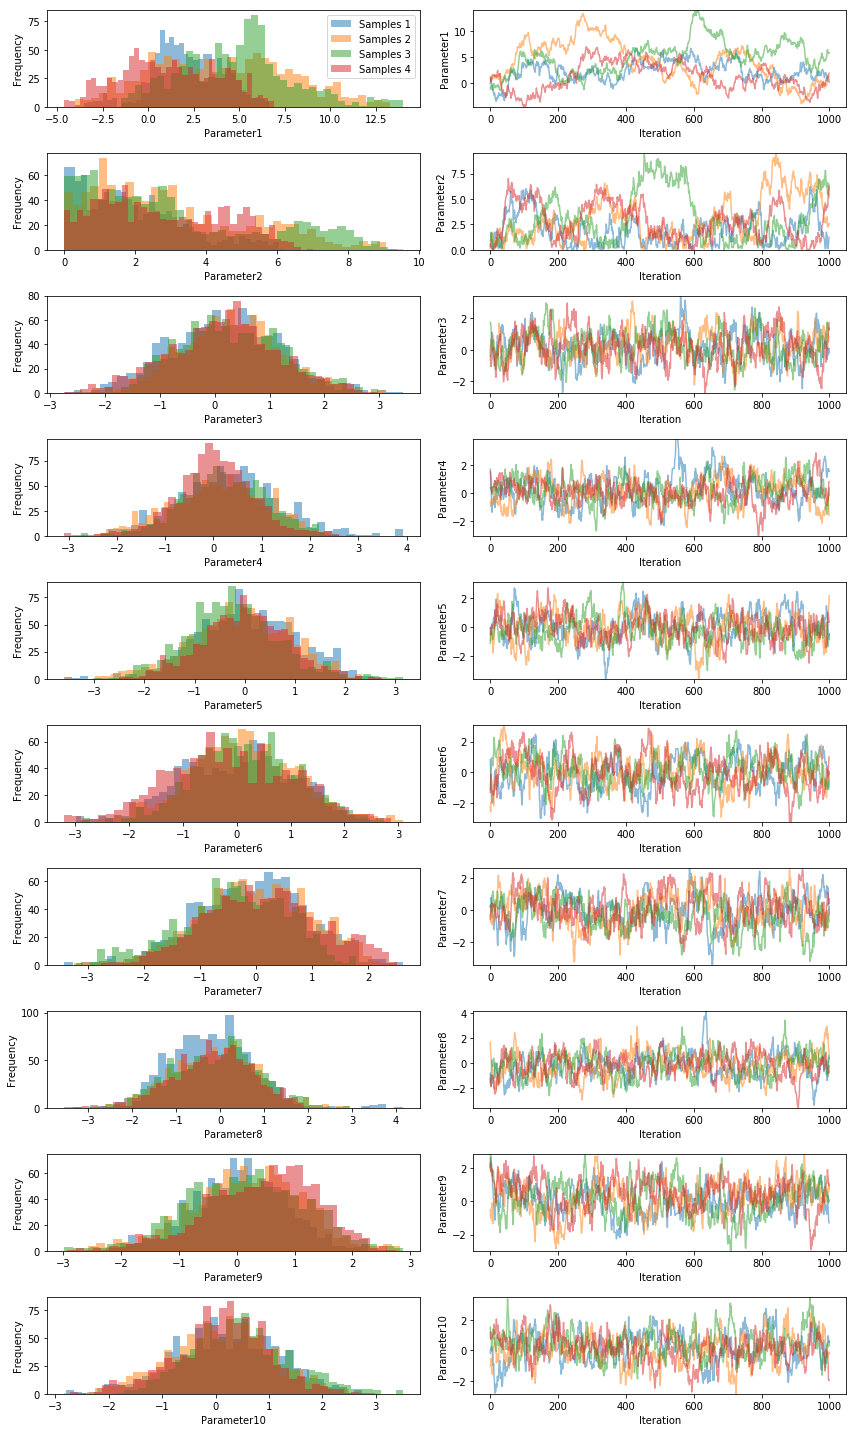

In [8]:
import pints.plot
pints.plot.trace(full_chains)
plt.show()